In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

Taylor Swift has been on music industry for more than 10 years; I've started listening to her song since I was in high school - roughly 8 years ago. Time flies, people change, and so do her songs. Her songs shifted from country to pop, and electropop on her Reputation album.

## Research Questions

Considering the various genres, do Taylor Swift's songs also contain various topics?

# Data Preparation

The song lyrics are scraped from lyrics.com; here we use 131 Taylor Swift's song lyrics.

In [3]:
df_song = pd.read_csv("dataset/lyrics/taylor-swift.csv")
df_song = df_song.drop_duplicates(subset='title',keep='first')

In [4]:
def clean_line(series):
    series = series.replace('\n',' ').replace('\r','').replace('\t','')
    return series

cols = ['lyrics','info','credits']
for col in cols:
    df_song[col] = df_song[col].apply(clean_line)

In [5]:
df_song['year'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[1] if ':' in x else None)
df_song['view'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[3].strip().replace('Views','') if ':' in x else x.replace('Views','').replace(' ',''))

In [6]:
from collections import Counter

wc = {}

for idx, row in df_song.iterrows():
    wc[row['title']] = Counter(row['lyrics'].lower().split())

In [7]:
_l = []
for key in wc.keys():
    _l.append(len(wc[key].items()))
    
df_song['unique_word'] = _l

# Analysis

*explain method you use on this analysis*

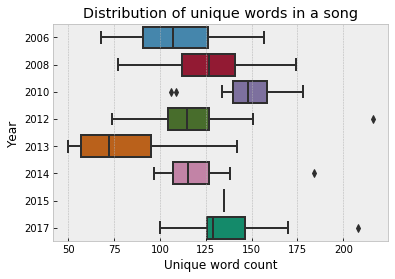

In [29]:
sns.boxplot(
    data=df_song.sort_values(by='year'),
    y='year',
    x='unique_word',
    orient='h'
);

plt.title("Distribution of unique words in a song")
plt.xlabel("Unique word count")
plt.ylabel("Year")
plt.show();

In [27]:
from wordcloud import WordCloud, STOPWORDS 

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0,
                          background_color = 'white',
                          random_state = 101,
                          width = 1200,
                          height = 600,
                          stopwords = {'to', 'of','and','the','but','as'} # set or space-separated string
                          ).generate(text)
    f, ax = plt.subplots(figsize=(12,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

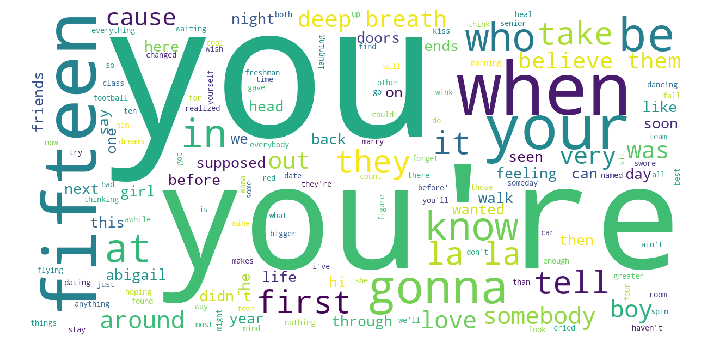

In [28]:
# create sample wordcloud for several songs
generate_wordcloud(df_song['lyrics'][0].lower())

Nah, we don't want to observe each song's word cloud and compare it one by one.. How about using more sophisticated method?

In [34]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from string import punctuation
from collections import Counter
import sys, re

In [54]:
from spacy.lang.en import English

nlp = English()
nlp.Defaults.stop_words.update(stop)

In [113]:
def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]

In [114]:
df_song['token'] = df_song['lyrics'].str.lower().map(tokenizer)

In [115]:
# store lyrics with cleaned tokens
_lyrics = []

for ix, row in df_song.iterrows():
    _txt = ''
    for word in row['token']:
        if word == ' ':
            continue
        else:
            _txt += word + ' '
    _lyrics.append(_txt)
    
df_song['lyrics_clean'] = _lyrics

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = tfidf_vec.fit_transform(df_song['lyrics_clean'])

In [117]:
tfidf = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
tfidf = pd.DataFrame(columns=['idf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['idf']

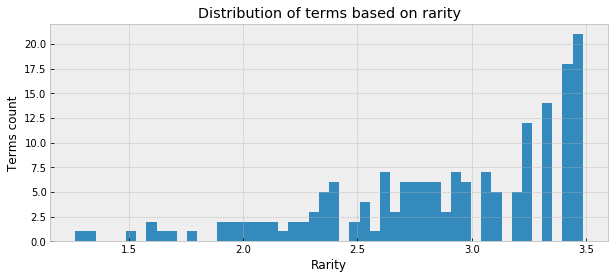

In [118]:
tfidf.idf.hist(bins=50, figsize=(10,4))
plt.xlabel("Rarity")
plt.ylabel("Terms count")
plt.title("Distribution of terms based on rarity")
plt.show()

In [119]:
print("More common terms:")
print(tfidf.sort_values(by=['idf'], ascending=True).head(10).index.values)

print("\n=========================\n")
print("Less common terms:")
print(tfidf.sort_values(by=['idf'], ascending=False).head(10).index.values)

More common terms:
['know' 'like' 'love' 'time' 'oh' 'think' 'come' 'look' 'right' 'tell']


Less common terms:
['young' 'read' 'figure' 'grind' 'deep' 'guess' 'hey' 'let know' 'lip'
 'listen']


## Dimensionality Reduction

In [105]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=50, random_state=101)
svd_tfidf = svd.fit_transform(vz)

In [110]:
# get number of unique tokens
_t = []

for ix, row in df_song.iterrows():
    for t in row['token']:
        if t not in _t:
            _t.append(t)
            
print("Number of unique tokens: {:,}".format((len(_t))))

Number of unique tokens: 1,804


In [111]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=101)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 131 samples in 0.001s...
[t-SNE] Computed neighbors for 131 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 131 / 131
[t-SNE] Mean sigma: 0.445674
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.262550
[t-SNE] Error after 1000 iterations: 0.786642


In [112]:
print("Dimension after SVD: ", svd_tfidf.shape)
print("Dimension after t-SNE: ", tsne_tfidf.shape)

Dimension after SVD:  (131, 50)
Dimension after t-SNE:  (131, 2)


# Results and Discussions

*describe what you find and how it can be improved*

# References



Morris, C. 2017. An Exercise in Language Compression: Are pop lyrics getting more repetitive? Accessed [here](https://pudding.cool/2017/05/song-repetition/).